In [17]:
# Comparativa Signal-to-Noise Ratio rGW-template

from gwpy.timeseries import TimeSeries
from pycbc.filter import matched_filter
from pycbc.waveform import get_fd_waveform


In [18]:
# Metodo de mayor demora
data = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)
high = data.highpass(15)
psd = high.psd(4, 2)
zoom = high.crop(1126259460, 1126259464)

In [19]:
# Generar un modelo en frecuencia
hp, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,
                        f_lower=20, f_final=2048, delta_f=psd.df.value)

# Comparar la señal real y el modelo
snr = matched_filter(hp, zoom.to_pycbc(), psd=psd.to_pycbc(),
                     low_frequency_cutoff=15)
snrts = TimeSeries.from_pycbc(snr).abs()


/home/robert/.conda/envs/gw_pyQt/lib/python3.10/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


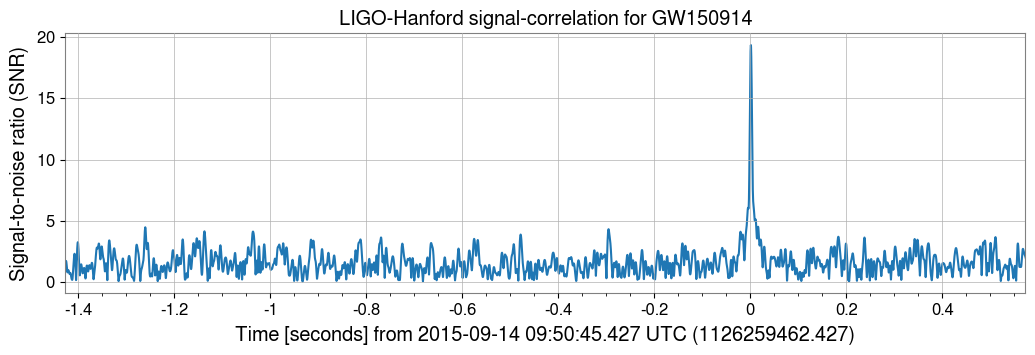

In [20]:
# Graficar los valores de SNR
plot = snrts.plot()
ax = plot.gca()
ax.set_xlim(1126259461, 1126259463)
ax.set_epoch(1126259462.427)
ax.set_ylabel('Signal-to-noise ratio (SNR)')
ax.set_title('LIGO-Hanford signal-correlation for GW150914')
plot.show()


/home/robert/.conda/envs/gw_pyQt/lib/python3.10/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


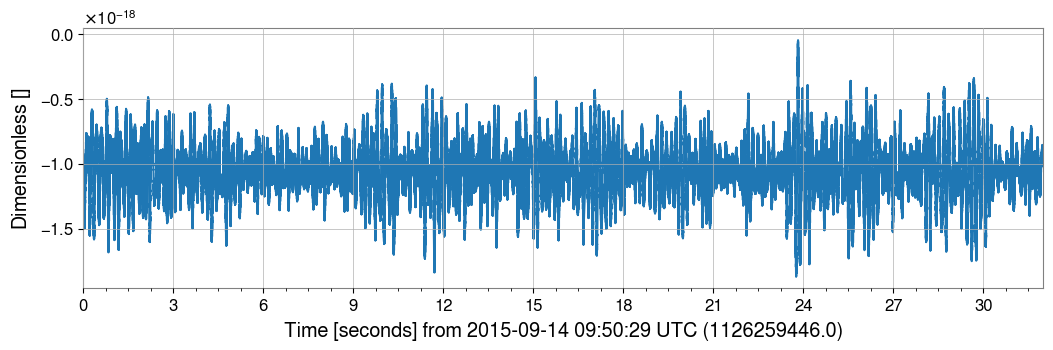

In [21]:
# Metodo de mayor demora (en distinto tiempo)
l1hoft = TimeSeries.fetch_open_data('L1', 'Sep 14 2015 09:50:29', 'Sep 14 2015 09:51:01')
plot = l1hoft.plot()
plot.show()


/home/robert/.conda/envs/gw_pyQt/lib/python3.10/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


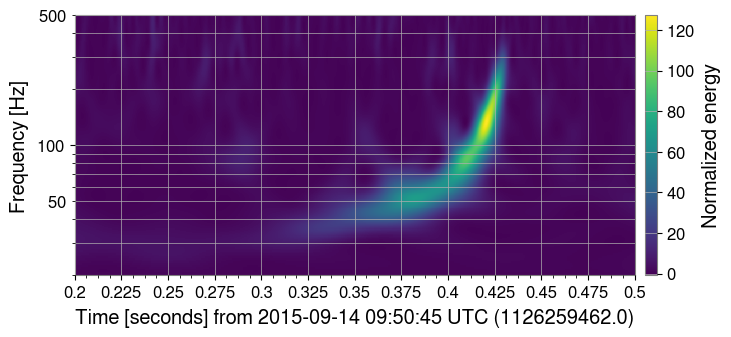

In [22]:
# Realizar la qTransorm a data
qspecgram = data.q_transform(outseg=(1126259462.2, 1126259462.5))
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

In [23]:
######## Metodo más rapido

In [27]:
######## Metodo más rapido

import pylab
from pycbc.frame import read_frame
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation


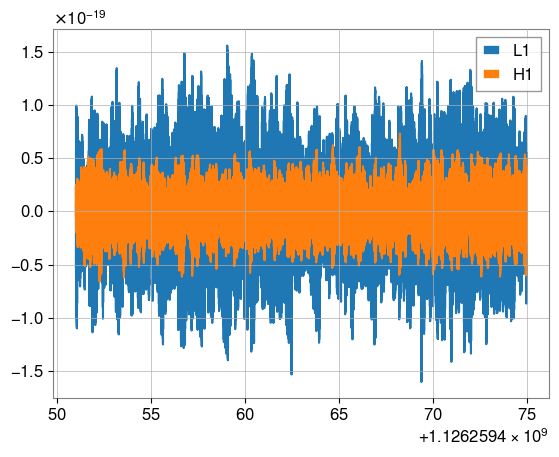

In [29]:
# Graficar el Strain completo de la lectura
m = Merger("GW150914")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # Aplicar un filtro para eliminar freceuncias bajas
    strain[ifo] = highpass(m.strain(ifo), 15)

    # Se recorta un segmento del strain
    strain[ifo] = strain[ifo].crop(4, 4)

    # Se modifica la serie de tiempo a una serie de frecuenias
    stilde[ifo] = strain[ifo].to_frequencyseries()
    
    #strain[ifo].save('tst'+str([ifo])+'.hdf')
    # graficar la serie mediante sus marcas de tiempo
    pylab.plot(strain[ifo].sample_times, strain[ifo], label=ifo)
pylab.legend()

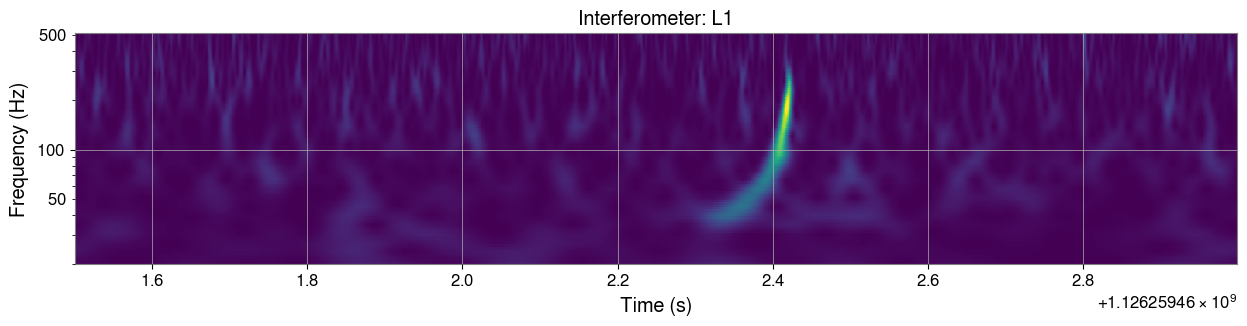

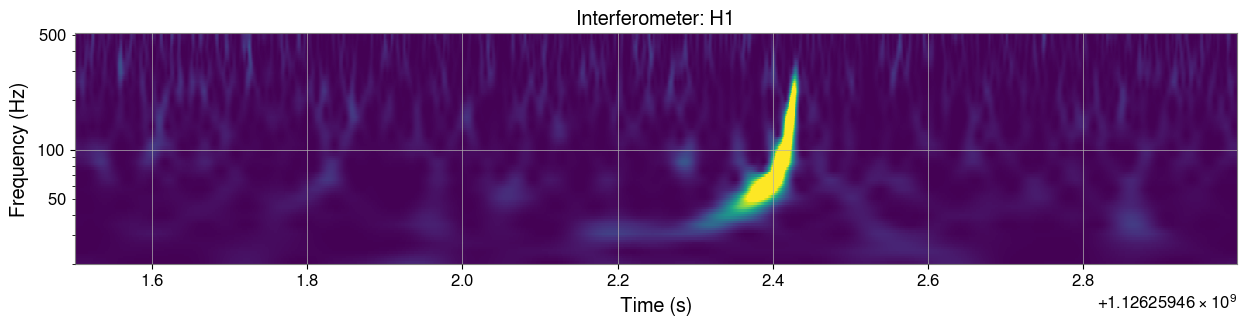

In [31]:
psds = {}
for ifo in ['L1', 'H1']:
    # Interpolar el strain a otra frecuencia para poder graficar
    psds[ifo] = interpolate(strain[ifo].psd(2), stilde[ifo].delta_f)

    # Se acorta el segmento a 2 segundos
    psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 * strain[ifo].sample_rate),
                                    low_frequency_cutoff=15.0,
                                    trunc_method='hann')

    # Filtrado Whithening
    hoft = (stilde[ifo] / psds[ifo] ** 0.5).to_timeseries()

    # Se selecciona una ventana de tiempo para la grafica
    zoom = hoft.time_slice(1126259461.5, 1126259463)
    
    #Se obtiene el espectrogrma
    times, freqs, power = zoom.qtransform(.001, logfsteps=100, frange=(20, 512), qrange=(8, 8))
    
    # Ajustes de la grafica
    pylab.figure(figsize=(15,3))
    pylab.pcolormesh(times, freqs, power, vmin=0, vmax=50)
    pylab.ylim(20, 512)
    pylab.title('Interferometer: %s' % ifo)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(times.min(), times.max())
    pylab.yscale('log')